In [40]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.readwrite import json_graph

In [20]:
import uuid
ep_ids = [uuid.uuid4() for i in range(7)]
print(ep_ids)

[UUID('84f43a73-faf8-479e-938f-03137cf01933'), UUID('de0a2eea-d2fe-4b05-88f9-4cd4d3f805a8'), UUID('536f9d6e-cb5e-4117-bc9b-b598f6c27215'), UUID('fbc1535a-1bd2-49b7-af76-0e43a3bc4676'), UUID('8552880f-669c-4926-aab0-4a47b0a304df'), UUID('e5f78c12-fb62-437e-8737-43b229dcf6aa'), UUID('15edab74-efff-4558-8e26-01705550e7c3')]


### Compose a balanced graph of 7 nodes

In [42]:
G = nx.DiGraph()
root = ep_ids[0]
G.add_node(ep_ids[0], kind="root")
G.add_node(ep_ids[1], kind="middle")
G.add_edge(ep_ids[0], ep_ids[1])
G.add_node(ep_ids[2], kind="middle")
G.add_edge(ep_ids[0], ep_ids[2])
G.add_node(ep_ids[3], kind="leaf")
G.add_edge(ep_ids[1], ep_ids[3])
G.add_node(ep_ids[4], kind="leaf")
G.add_edge(ep_ids[1], ep_ids[4])
G.add_node(ep_ids[5], kind="leaf")
G.add_edge(ep_ids[2], ep_ids[5])
G.add_node(ep_ids[6], kind="leaf")
G.add_edge(ep_ids[2], ep_ids[6])

if nx.is_tree(G):
    print("We have a tree")

We have a tree


### Visualize the graph

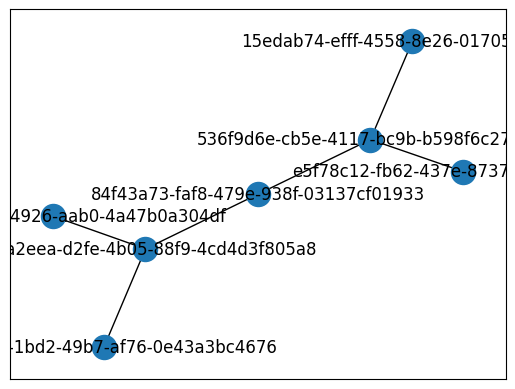

In [34]:
nx.draw_networkx(G, arrows=True)

### Save and load the graph to/from JSON

In [43]:
json_graph.tree_data(G, root=ep_ids[0])

{'kind': 'root',
 'id': UUID('84f43a73-faf8-479e-938f-03137cf01933'),
 'children': [{'kind': 'middle',
   'id': UUID('de0a2eea-d2fe-4b05-88f9-4cd4d3f805a8'),
   'children': [{'kind': 'leaf',
     'id': UUID('fbc1535a-1bd2-49b7-af76-0e43a3bc4676')},
    {'kind': 'leaf', 'id': UUID('8552880f-669c-4926-aab0-4a47b0a304df')}]},
  {'kind': 'middle',
   'id': UUID('536f9d6e-cb5e-4117-bc9b-b598f6c27215'),
   'children': [{'kind': 'leaf',
     'id': UUID('e5f78c12-fb62-437e-8737-43b229dcf6aa')},
    {'kind': 'leaf', 'id': UUID('15edab74-efff-4558-8e26-01705550e7c3')}]}]}

### Traverse the graph and translate to series of operations

In the simplified case that Nathaniel and I discussed, we are expecting a tree of height 3, where there are a handful 
of middle nodes representing logical clusters and each cluster parenting several leaf nodes. 

* If a middle node also wants to train, then the user has to start an EP to represent it as a leaf node where training
can happen

In [50]:
attribs = nx.get_node_attributes(G, 'kind')
for node in nx.dfs_tree(G, ep_ids[0]):
    print(node, attribs[node])

84f43a73-faf8-479e-938f-03137cf01933 root
de0a2eea-d2fe-4b05-88f9-4cd4d3f805a8 middle
fbc1535a-1bd2-49b7-af76-0e43a3bc4676 leaf
8552880f-669c-4926-aab0-4a47b0a304df leaf
536f9d6e-cb5e-4117-bc9b-b598f6c27215 middle
e5f78c12-fb62-437e-8737-43b229dcf6aa leaf
15edab74-efff-4558-8e26-01705550e7c3 leaf


### Simple recursive call chain

Here we iterate over the graph and we launch train tasks on the leaf nodes and aggregate over all the children for 
non-leaf nodes

In [65]:
def train(x: int)-> int:
    return x + 1

def aggregate(deltas: list) -> int:
    return sum(deltas)

def recursive_nav(G, current, attribs):
    my_type = attribs[current]
    if attribs[current] == "leaf":
        print(f"[{my_type}] Train(1) on leaf:{current}")
        return train(0)
    else:
        print(f"[{my_type}] Initiating recursive train on children of {current}")
        child_results = [recursive_nav(G, n, attribs) for n in G.successors(current)]
        print(f"[{my_type}] Got results {child_results}")
        print(f"[{my_type}] Aggregating on node:{current}")
        return aggregate(child_results)


In [66]:
recursive_nav(G, ep_ids[0], attribs)

[root] Initiating recursive train on children of 84f43a73-faf8-479e-938f-03137cf01933
[middle] Initiating recursive train on children of de0a2eea-d2fe-4b05-88f9-4cd4d3f805a8
[leaf] Train(1) on leaf:fbc1535a-1bd2-49b7-af76-0e43a3bc4676
[leaf] Train(1) on leaf:8552880f-669c-4926-aab0-4a47b0a304df
[middle] Got results [1, 1]
[middle] Aggregating on node:de0a2eea-d2fe-4b05-88f9-4cd4d3f805a8
[middle] Initiating recursive train on children of 536f9d6e-cb5e-4117-bc9b-b598f6c27215
[leaf] Train(1) on leaf:e5f78c12-fb62-437e-8737-43b229dcf6aa
[leaf] Train(1) on leaf:15edab74-efff-4558-8e26-01705550e7c3
[middle] Got results [1, 1]
[middle] Aggregating on node:536f9d6e-cb5e-4117-bc9b-b598f6c27215
[root] Got results [2, 2]
[root] Aggregating on node:84f43a73-faf8-479e-938f-03137cf01933


4

In [87]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from concurrent.futures import Future
from functools import partial
# executor = ProcessPoolExecutor(max_workers=2)
executor = ThreadPoolExecutor()

In [92]:
def s_train(x: int)-> int:
    import time
    import random
    time.sleep(1 + random.random())
    return x + 1

def s_aggregate(deltas: list) -> int:
    import time
    time.sleep(1)
    return sum(deltas)

### Delayed aggr with callbacks

We would like to trigger aggregation tasks on 
1) trigger aggr on completion of all child tasks
2) a subset of child train/aggr tasks based on timeouts to account for failures
3) the parent context where aggr tasks can be launched onto remote workers

To do the above, 
1) the callbacks need to have info on **all** the child futures it is dependent on
2) the callback needs to be triggerable by some deadline which could be a separate future that we spin off
3) callbacks will naturally trigger in the parent context.
4) we need to mint a future to pass to the parent proc to represent an aggr task that will be launched in the future

In [101]:
import logging

def set_parent_fu(parent_fu, child_fu):
    assert child_fu.done()
    print("Child setting parent fu")
    if child_fu.exception():
        parent_fu.set_exception(child_fu.exception())
    else:
        result = child_fu.result()
        try:
            parent_fu.set_result(result)
        except Exception:
            logging.exception("Failed")

def callback(child_futures, future_of_self, child_future_that_resolved):
    print(f"Callback triggered: {[f.done() for f in child_futures]}")
    # This is the simplest logic, where we trigger the aggr tasks when all
    # child procs have completed
    if all([f.done() for f in child_futures]):
        child_results = [f.result() for f in child_futures]
        future = executor.submit(s_aggregate, child_results)
        custom_cbk = partial(set_parent_fu, future_of_self)
        future.add_done_callback(custom_cbk)


def recursive_nav_f(G, current, attribs) -> Future:
    my_type = attribs[current]
    if attribs[current] == "leaf":
        print(f"[{my_type}] Train(1) on leaf:{current}")
        future = executor.submit(s_train, 0)
        return future
    else:
        print(f"[{my_type}] Initiating recursive train on children of {current}")
        child_futures = [recursive_nav_f(G, n, attribs) for n in G.successors(current)]
        print(f"{child_futures=}")
        self_future = Future()
        custom_cbk = partial(callback, child_futures, self_future)
        for child_fu in child_futures:
            child_fu.add_done_callback(custom_cbk)
        
        return self_future

In [100]:
recursive_nav_f(G, ep_ids[0], attribs)

[root] Initiating recursive train on children of 84f43a73-faf8-479e-938f-03137cf01933
[middle] Initiating recursive train on children of de0a2eea-d2fe-4b05-88f9-4cd4d3f805a8
[leaf] Train(1) on leaf:fbc1535a-1bd2-49b7-af76-0e43a3bc4676
[leaf] Train(1) on leaf:8552880f-669c-4926-aab0-4a47b0a304df
child_futures=[<Future at 0x7fb12823d390 state=pending>, <Future at 0x7fb12823fc70 state=pending>]
[middle] Initiating recursive train on children of 536f9d6e-cb5e-4117-bc9b-b598f6c27215
[leaf] Train(1) on leaf:e5f78c12-fb62-437e-8737-43b229dcf6aa
[leaf] Train(1) on leaf:15edab74-efff-4558-8e26-01705550e7c3
child_futures=[<Future at 0x7fb11a31c9a0 state=pending>, <Future at 0x7fb11a31cfa0 state=pending>]
child_futures=[<Future at 0x7fb12823ee30 state=pending>, <Future at 0x7fb11a31c940 state=pending>]


<Future at 0x7fb128220370 state=pending>

Callback triggered: [True, False]
Callback triggered: [False, True]
Callback triggered: [True, True]
Child setting parent fu
Callback triggered: [True, False]
Callback triggered: [True, True]
Child setting parent fu
Callback triggered: [True, True]
Child setting parent fu
